# SVM SIMPLE PIPELINE

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_pipeline import *
from utils_evaluate import *
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
import os
from sklearn.svm import SVC


In [2]:
BASE_DIR = os.getcwd()

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_firstorder_glcm_glrlm_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAIN_DIR = os.path.join(DATA_DIR,"TrainningDataset_reduced.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TEST_DIR = os.path.join(DATA_DIR,"TestingDataset_reduced.csv")


In [3]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv(TRAIN_DIR)
y = pd.read_csv(LABEL_DIR)
X_test = pd.read_csv(TEST_DIR)

# Assurez-vous que les identifiants sont bien formatés avec des zéros
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Mélange des lignes de X
X = X.sample(frac=1, random_state=42).reset_index(drop=True)

# Réalignement parfait de y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]

# Séparation des features
X_train = X.drop(columns=["Id"])

X_test["Id"] = X_test["Id"].astype(str).str.zfill(3)
X_test = X_test.drop(columns=["Id"])


In [4]:
pipeline = ImbPipeline([ 
    ("normaliser" , StandardScaler()),                  
    ("classifier", SVC(probability=True)),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'classifier', 'normaliser__copy', 'normaliser__with_mean', 'normaliser__with_std', 'classifier__C', 'classifier__break_ties', 'classifier__cache_size', 'classifier__class_weight', 'classifier__coef0', 'classifier__decision_function_shape', 'classifier__degree', 'classifier__gamma', 'classifier__kernel', 'classifier__max_iter', 'classifier__probability', 'classifier__random_state', 'classifier__shrinking', 'classifier__tol', 'classifier__verbose'])

In [5]:
# Cross Validation
# Seed of randomness to be able to compare different model more accuratly
cv = StratifiedKFold(shuffle=True)

In [6]:
param_grid = {
    'classifier__C': [0.1, 0.5, 1, 3, 5, 7, 10, 15, 20, 30, 50],
    'classifier__tol': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    'classifier__shrinking': [True, False],
    'classifier__cache_size': [200],
    'classifier__kernel': ['linear']  # fixed to linear
}


In [7]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=cv,verbose=3,return_train_score=True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
[CV 1/5] END classifier__C=0.1, classifier__cache_size=200, classifier__kernel=linear, classifier__shrinking=True, classifier__tol=0.0001;, score=(train=1.000, test=0.900) total time=   0.0s
[CV 2/5] END classifier__C=0.1, classifier__cache_size=200, classifier__kernel=linear, classifier__shrinking=True, classifier__tol=0.0001;, score=(train=0.988, test=0.850) total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__cache_size=200, classifier__kernel=linear, classifier__shrinking=True, classifier__tol=0.0001;, score=(train=0.988, test=1.000) total time=   0.0s
[CV 4/5] END classifier__C=0.1, classifier__cache_size=200, classifier__kernel=linear, classifier__shrinking=True, classifier__tol=0.0001;, score=(train=0.975, test=0.850) total time=   0.0s
[CV 5/5] END classifier__C=0.1, classifier__cache_size=200, classifier__kernel=linear, classifier__shrinking=True, classifier__tol=0.0001;, score=(train=1.000, test=0.800) t

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('normaliser', StandardScaler()),
                                       ('classifier', SVC(probability=True))]),
             param_grid={'classifier__C': [0.1, 0.5, 1, 3, 5, 7, 10, 15, 20, 30,
                                           50],
                         'classifier__cache_size': [200],
                         'classifier__kernel': ['linear'],
                         'classifier__shrinking': [True, False],
                         'classifier__tol': [0.0001, 0.0005, 0.001, 0.005,
                                             0.01]},
             return_train_score=True, verbose=3)

The model is fitted and now we want to properly evaluate the results. 
We select only the result from the best_params founded by the search. (Reminder that the best params are the one that provided the best mean validation score)

In [8]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : {'classifier__C': 0.5, 'classifier__cache_size': 200, 'classifier__kernel': 'linear', 'classifier__shrinking': True, 'classifier__tol': 0.001} 
score validation set : (0.9, 0.07071067811865474)
score trainning set : (1.0, 0.0)


In [9]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', StandardScaler()), ('classifier', SVC(C=0.5, kernel='linear', probability=True))], 'verbose': False, 'normaliser': StandardScaler(), 'classifier': SVC(C=0.5, kernel='linear', probability=True), 'normaliser__copy': True, 'normaliser__with_mean': True, 'normaliser__with_std': True, 'classifier__C': 0.5, 'classifier__break_ties': False, 'classifier__cache_size': 200, 'classifier__class_weight': None, 'classifier__coef0': 0.0, 'classifier__decision_function_shape': 'ovr', 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'classifier__max_iter': -1, 'classifier__probability': True, 'classifier__random_state': None, 'classifier__shrinking': True, 'classifier__tol': 0.001, 'classifier__verbose': False}


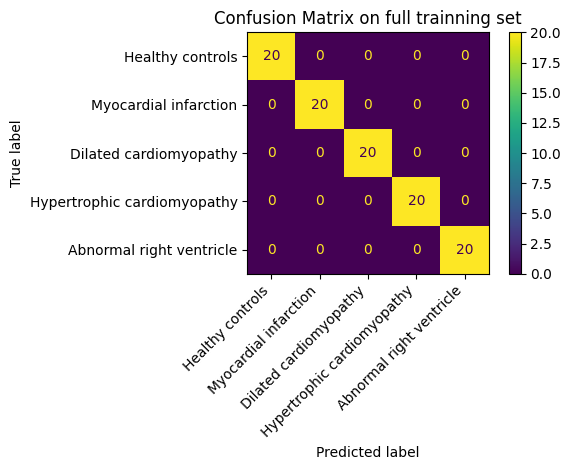

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [10]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X_train)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.show()

print(classification_report(y_train,y_pred))

In [11]:
# Get the probabilities to get better insight on the model performance

proba = inf_pipeline.predict_proba(X_train)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")
# Below 
treshold = 0.4
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.6267648208134636

average margin score : 0.742986298048576

[0, 0, 0, 0, 0]


In [12]:
# Predict on the test set
import os

submission_name = "submission_svm_linear_mrmr_23_radiomics.csv"
submission_dataframe = pd.DataFrame(columns=["Id","Category"])
submission_dataframe["Id"] = X_test.index + 101 

y_test_pred = inf_pipeline.predict(X_test)
submission_dataframe["Category"] = y_test_pred
submission_dataframe.to_csv(os.path.join(os.getcwd(),submission_name),index=False)

print("File saved")

File saved


Below two cells to save the results : the model and the description of the method used.

In [13]:
description = "StandardScaler + SVM. radiomics featues + MRMR." 
other_params = ""
name_folder = "SVM_RADIOMICS_MRMR_30"
informationDict = {
    "description": description,
    "model parameters" : best_params,
    "mean test accuracy with best params" : mean_valid_score ,
    "std  test with best params" : std_valid_score,
    "mean train accuracy with best params" : mean_train_score,
    "std train best params" : std_train_score,
    "other parms" : other_params,
    
}

# REPREDICTING PREDICTION THAT HAVE LOW PROBABILITIES

In [14]:
import joblib
from datetime import datetime
import os

# Create a timestamp
currentDateTime = datetime.now()

# Get the base directory (current directory)
BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")
RESULT_DIR = os.path.join(BASE_DIR,"output")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    print(f"Directory created: {RESULT_DIR}")

# Create a folder named 'pipeline_<timestamp>' in the current directory
dir_name = name_folder
dir_path = os.path.join(RESULT_DIR, dir_name)

# If the directory doesn't exist, create it
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
    print(f"Directory created: {dir_path}")

# Save the model inside this new folder
model_filename = 'pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.pkl'
model_path = os.path.join(dir_path, model_filename)

# This is where you'd have your model defined
joblib.dump(grid_search, model_path)
print(f"Model saved to: {model_path}")



# SAVING Description 
dict_filename = 'params.txt'
dict_path = os.path.join(dir_path, dict_filename)

with open(dict_path, 'w') as f:
    for key, val in informationDict.items():
        f.write(f"{key} : {val}\n")
print(f"Information about the model saved to: {dict_path}")


BASE_DIR: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction
Model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/SVM_RADIOMICS_MRMR_30/pipeline_09-14-46.pkl
Information about the model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/SVM_RADIOMICS_MRMR_30/params.txt
